In [1]:

def water(index, data, Title="", x_lab="", y_lab="",
              formatting = "{:,.1f}", green_color='#29EA38', red_color='#FB3C62', blue_color='#24CAFF',
             sorted_value = False, threshold=None, other_label='other', net_label='net', 
             rotation_value = 30, blank_color=(0,0,0,0), figsize = (10.871,5.515)):
    '''
    Given two sequences ordered appropriately, generate a standard waterfall chart.
    Optionally modify the title, axis labels, number formatting, bar colors, 
    increment sorting, and thresholding. Thresholding groups lower magnitude changes
    into a combined group to display as a single entity on the chart.
    '''
    
    #convert data and index to np.array
    index=np.array(index)
    data=np.array(data)
    
    # wip
    #sorted by absolute value 
    if sorted_value: 
        abs_data = abs(data)
        data_order = np.argsort(abs_data)[::-1]
        data = data[data_order]
        index = index[data_order]
    
    #group contributors less than the threshold into 'other' 
    if threshold:
        
        abs_data = abs(data)
        threshold_v = abs_data.max()*threshold
        
        if threshold_v > abs_data.min():
            index = np.append(index[abs_data>=threshold_v],other_label)
            data = np.append(data[abs_data>=threshold_v],sum(data[abs_data<threshold_v]))
    
    changes = {'amount' : data}
    
    #define format formatter
    def money(x, pos):
        'The two args are the value and tick position'
        return formatting.format(x)
    formatter = FuncFormatter(money)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.yaxis.set_major_formatter(formatter)

    #Store data and create a blank series to use for the waterfall
    trans = pd.DataFrame(data=changes,index=index)
    blank = trans.amount.cumsum().shift(1).fillna(0)
    
    trans['positive'] = trans['amount'] > 0

    #Get the net total number for the final element in the waterfall
    total = trans.sum().amount
    trans.loc[net_label]= total
    blank.loc[net_label] = total

    #The steps graphically show the levels as well as used for label placement
    step = blank.reset_index(drop=True).repeat(3).shift(-1)
    step[1::3] = np.nan

    #When plotting the last element, we want to show the full bar,
    #Set the blank to 0
    blank.loc[net_label] = 0
    
    #define bar colors for net bar
    trans.loc[trans['positive'] > 1, 'positive'] = 99
    trans.loc[trans['positive'] < 0, 'positive'] = 99
    trans.loc[(trans['positive'] > 0) & (trans['positive'] < 1), 'positive'] = 99
    
    trans['color'] = trans['positive']
    
    trans.loc[trans['positive'] == 1, 'color'] = green_color
    trans.loc[trans['positive'] == 0, 'color'] = red_color
    trans.loc[trans['positive'] == 99, 'color'] = blue_color
    
    my_colors = list(trans.color)
    
    #Plot and label
    my_plot = plt.bar(range(0,len(trans.index)), blank, width=0.5, color=blank_color)
    plt.bar(range(0,len(trans.index)), trans.amount, width=0.6,
             bottom=blank, color=my_colors)       
                                   
    
    # connecting lines - figure out later
    #my_plot = lines.Line2D(step.index, step.values, color = "gray")
    #my_plot = lines.Line2D((3,3), (4,4))
    
    #axis labels
    plt.xlabel("\n" + x_lab)
    plt.ylabel(y_lab + "\n")

    #Get the y-axis position for the labels
    y_height = trans.amount.cumsum().shift(1).fillna(0)
    
    temp = list(trans.amount)
    
    # create dynamic chart range
    for i in range(len(temp)):
        if (i > 0) & (i < (len(temp) - 1)):
            temp[i] = temp[i] + temp[i-1]
    
    trans['temp'] = temp
            
    plot_max = trans['temp'].max()
    plot_min = trans['temp'].min()
    
    #Make sure the plot doesn't accidentally focus only on the changes in the data
    if all(i >= 0 for i in temp):
        plot_min = 0
    if all(i < 0 for i in temp):
        plot_max = 0
    
    if abs(plot_max) >= abs(plot_min):
        maxmax = abs(plot_max)   
    else:
        maxmax = abs(plot_min)
        
    pos_offset = maxmax / 40
    
    plot_offset = maxmax / 15 ## needs to me cumulative sum dynamic

    #Start label loop
    loop = 0
    for index, row in trans.iterrows():
        # For the last item in the list, we don't want to double count
        if row['amount'] == total:
            y = y_height[loop]
        else:
            y = y_height[loop] + row['amount']
        # Determine if we want a neg or pos offset
        if row['amount'] > 0:
            y += (pos_offset*2)
            plt.annotate(formatting.format(row['amount']),(loop,y),ha="center", color = 'k', fontsize=12)
        else:
            y -= (pos_offset*4)
            plt.annotate(formatting.format(row['amount']),(loop,y),ha="center", color = 'k', fontsize=12)
        loop+=1

    #Scale up the y axis so there is room for the labels
    plt.ylim(plot_min-round(3.6*plot_offset, 7),plot_max+round(3.6*plot_offset, 7))
    
    #Rotate the labels
    plt.xticks(range(0,len(trans)), trans.index, rotation=rotation_value)
    
    #add zero line and title
    plt.axhline(0, color='black', linewidth = 0.6, linestyle="dashed")
    plt.title(Title)
    plt.tight_layout()

    return fig, ax

In [2]:
# from IPython.display import Markdown, display

# display(Markdown("000_independencia_energetica.md"))
# https://www.kaggle.com/code/imdevskp/geopandas/notebook

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
# from dateutil.parser  import parse
# import waterfall_chart
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter

import geopandas as gpd

import matplotlib as mpl

mpl.rcParams.keys()
mpl.rcParams['lines.linewidth']         = 2
mpl.rcParams['lines.markersize']        = 10
mpl.rcParams['lines.markerfacecolor']   = "white"
mpl.rcParams['font.family']             = 'sans-serif'
mpl.rcParams['font.sans-serif']         = "Tahoma"
mpl.rcParams['font.size']               = 16

# colores
azulier        = "#1A3D6F"
naranjaier     = '#C65C25'
amarilloclaro  = '#f6ec7f'
naranja        = '#d8a700'
tamanio  = (10.871,5.515)
mpl.rcParams["figure.figsize"] = tamanio

# mpl.rcParams['lines.linestyle'] = '--'
# mpl.rcParams['lines.linestyle'] = '--'

In [4]:
# pip install mapclassify --upgrade

In [5]:

f = 'https://docs.google.com/spreadsheets/d/' + '1000UCid4YLrPbrn5WmXpo08Eoi3D3ipLP_rThk-1Jko' + '/export?gid=0&format=csv'
ps = pd.read_csv(f,index_col=5)
ps.sort_index(inplace=True)
# ps.columns
ps

,Empresa,NOMEDO,Estado,Lat,Lon,Unnamed: 6,Nombre del colector,Tipo de colector,"Area instalada (gross), m2","Área instalada (apertura), m2","Installed thermal power , kWth",Solar collector loop heat transfer fluid,Solar energy storage,"Storage volume, m³",Kind of conventional heat source,Kind of fuel used
Inicio de operación,,,,,,,,,,,,,,,,
2012.0,Lacto Productos El Indio,Michoacan,"San José de Gracia, Michoacán",NaN,NaN,other process heating,Power Trough 110,parabolic trough collector,401.10,132,74.00,water,short-term water storage,5,steam boiler,fuel oil
2013.0,Matatlan Dairy,Jalisco,"Matatlán, Zapotlanejo, Jalisco.",NaN,NaN,general processing heating,Power Trough 110,parabolic trough collector,66.00,NaN,46.20,water,short-term water storage,2.5,steam boiler,other
2013.0,Buenavista Greenhouse,Jalisco,"Buenavista, Jalisco, México",NaN,NaN,heating of producction halls,Power Trough 110,parabolic trough collector,112.00,66,36.00,water,short-term water storage,2.5,hot water boiler,natural gas
2013.0,Durango Dairy Company (Productos Lácteos COVBARS),Durango,"Av. Francisco Villa 1211, Villa de Guadalupe, ...",24.033543,-104.686407,Pasteurización,Power Trough 110,parabolic trough collector,265.68,132,46.20,water,short-term water storage,7,steam boiler,fuel oil
2014.0,Biotecnología Mexicana de Microalgas S.A. de C.V.,Jalisco,"Zapopan, Jalisco, Mexico",NaN,NaN,general processing heating,Power Trough 110,parabolic trough collector,110.00,66,31.67,water,short-term water storage,10,NaN,NaN
2014.0,Quesos La Doñita,Guanajuato,"Neutla, Guanajuato, Mexico",NaN,NaN,Pasteurización,Power Trough 110,parabolic trough collector,66.00,39.6,22.20,water,short-term water storage,1.5,hot water boiler,natural gas
2014.0,Nutrición Marina,Sinaloa,Carretera Federal Libre Los Mochis - San Migue...,NaN,NaN,Cooking,Power Trough 110,parabolic trough collector,310.00,178.2,97.20,water,short-term water storage,7.5,steam boiler,fuel oil
2014.0,NESTLE DAIRY PLANT LAGOS DE MORENO,Jalisco,"Lagos de Moreno, Jalisco",21.368154,-101.922474,Pasteurización,Power Trough 110,parabolic trough collector,1327.59,462,137.00,water,short-term water storage,5,steam boiler,natural gas
2014.0,NESTLE DAIRY PLANT CHAPA DE CORZO,Chiapas,"Chiapa de Corzo, México\t\n",16.706989,-93.002907,Pasteurización,Power Trough 110,parabolic trough collector,460.00,224.5,126.00,water,short-term water storage,5,steam boiler,other


In [6]:
# ps['Installed thermal power , kWth']

In [7]:
ps['Installed thermal power , kWth'].groupby(by=[ps.index]).sum()

Inicio de operación
2012.0      74.00
2013.0     128.40
2014.0     476.79
2015.0     897.00
2016.0      86.99
2017.0    1206.02
2018.0     288.68
2019.0     266.00
Name: Installed thermal power , kWth, dtype: float64

In [8]:
ps['Installed thermal power , kWth'].groupby(by=[ps.index]).sum().cumsum()

Inicio de operación
2012.0      74.00
2013.0     202.40
2014.0     679.19
2015.0    1576.19
2016.0    1663.18
2017.0    2869.20
2018.0    3157.88
2019.0    3423.88
Name: Installed thermal power , kWth, dtype: float64

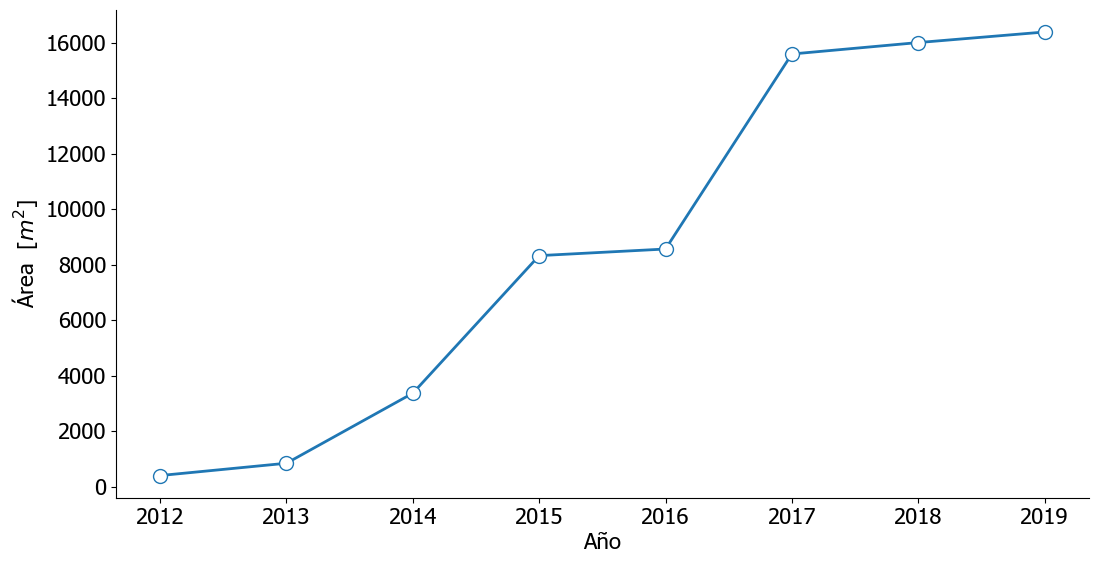

In [9]:
fig, ax = plt.subplots(constrained_layout=True,figsize=tamanio)


ax.plot(ps['Area instalada (gross), m2'].groupby(by=[ps.index]).sum().cumsum(), '-o',
        label="Area instalada")

ax.set_ylabel("Área  [$m^2$]")
ax.set_xlabel('Año')
ax.spines[['top','right']].set_visible(False)
plt.savefig('AreaInstalada.png')

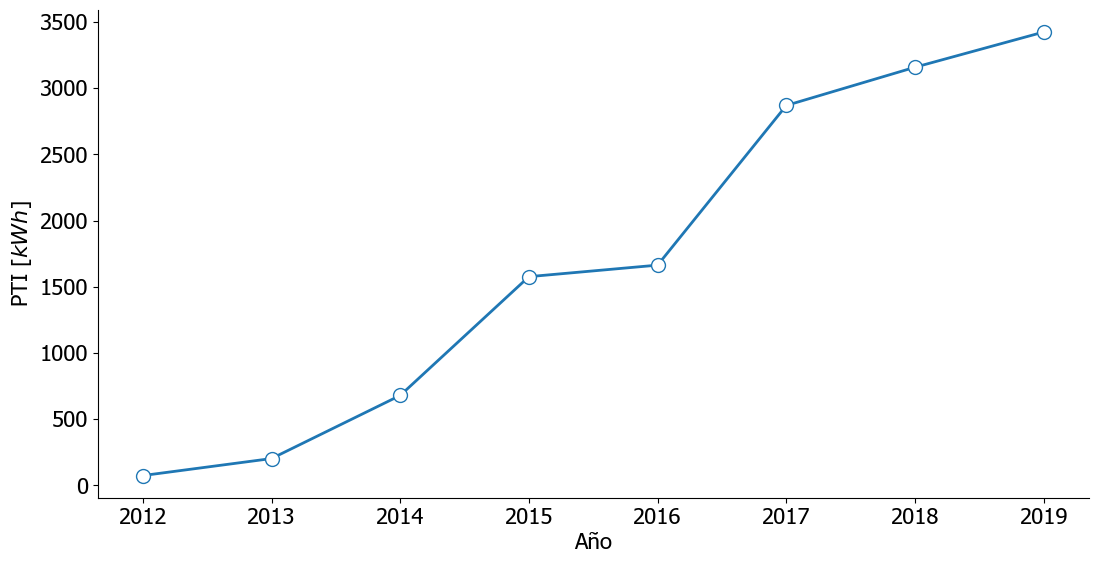

In [10]:
fig, ax = plt.subplots(constrained_layout=True,figsize=tamanio)


ax.plot(ps['Installed thermal power , kWth'].groupby(by=[ps.index]).sum().cumsum(), '-o',
        label="Area instalada")


ax.set_ylabel("PTI [$kWh$]")
ax.set_xlabel('Año')
ax.spines[['top','right']].set_visible(False)
plt.savefig('PotenciaTermicaInstalada.png')

/var/folders/2z/fh3yv7r50rxgy804jm3f7b0c0000gn/T/ipykernel_46337/1113556156.py:58: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  step[1::3] = np.nan


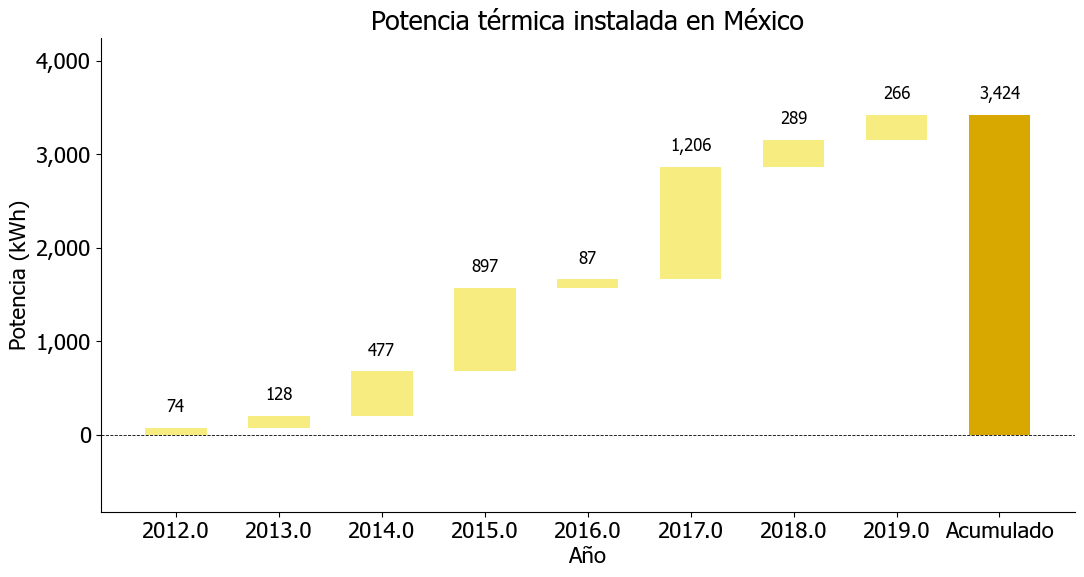

In [11]:
a = ps['Installed thermal power , kWth'].groupby(by=[ps.index]).sum().index.to_list()
a  = [str(A) for A in a]
b = ps['Installed thermal power , kWth'].groupby(by=[ps.index]).sum().to_list()

water(a, b, 
     rotation_value=0, 
     sorted_value=False,
     formatting="{:,.0f}",
     net_label='Acumulado',
     other_label='Peor año',
     blue_color=naranja, 
     green_color=amarilloclaro, 
     red_color='blue')
plt.title('Potencia térmica instalada en México')
plt.ylabel('Potencia (kWh)')
plt.xlabel('Año')
sns.despine()


In [12]:
# worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# mex =worldmap.loc[worldmap.iso_a3=='MEX']

# fig, ax = plt.subplots(figsize=tamanio)
# mex =worldmap.loc[worldmap.iso_a3=='MEX']
# mex.plot(color="grey", ax=ax)

# # Plotting our Impact Energy data with a color map
# x = ps.Lon
# y = ps.Lat
# z = ps['Installed thermal power , kWth']
# mapa = ax.scatter(x, y, s=0.5*z, c=z, alpha=0.6, vmin=0,
#             cmap='jet')
# fig.colorbar(mapa,label='Potencia instalada [kWh]')

 
# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")

In [13]:
mx   = gpd.read_file('mapa_mexico/').set_index('NOMEDO').to_crs(epsg=4485)
base = gpd.read_file('mapa_mexico/').set_index('NOMEDO').to_crs(epsg=4485)


f = 'https://docs.google.com/spreadsheets/d/' + '1000UCid4YLrPbrn5WmXpo08Eoi3D3ipLP_rThk-1Jko' + '/export?gid=0&format=csv'
plantas = pd.read_csv(f,index_col='NOMEDO')
plantas = plantas[['Installed thermal power , kWth']].groupby(by='NOMEDO').sum()
mx = mx.join(plantas,how='left')
# mx

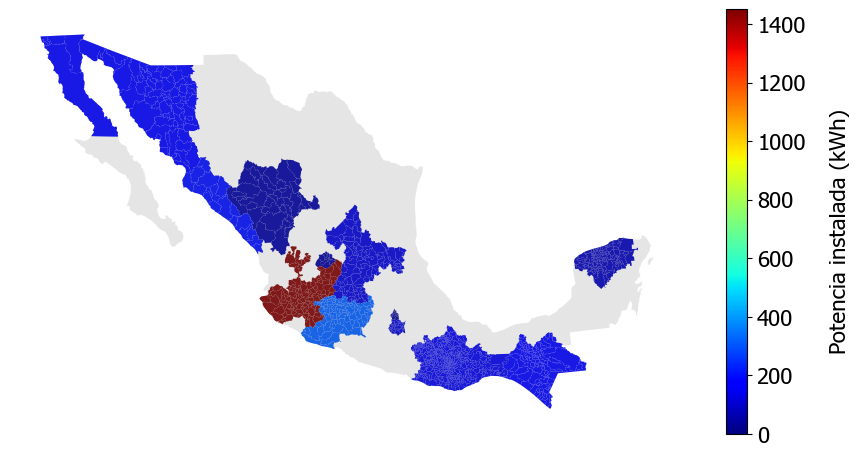

In [14]:
fig, ax = plt.subplots(figsize=tamanio)

barra = mx.plot(column='Installed thermal power , kWth', ax=ax,
                legend=True,cmap='jet',vmin=0)
base.plot(ax=ax,alpha=0.2,color='grey')


# fig.subplots_adjust(right=1)
ax.text(4e6,2.0e6, "Potencia instalada (kWh)",rotation="vertical")
ax.set_axis_off()


In [15]:
ps[["Installed thermal power , kWth"]].loc[ps.NOMEDO=="Jalisco"]

,"Installed thermal power , kWth"
Inicio de operación,
2013.0,46.20
2013.0,36.00
2014.0,31.67
2014.0,137.00
2014.0,62.72
2015.0,240.00
2015.0,22.20
2015.0,94.50
2015.0,94.60


In [16]:
ps.groupby(by=["NOMEDO","Inicio de operación"]).sum()[["Installed thermal power , kWth"]]

/var/folders/2z/fh3yv7r50rxgy804jm3f7b0c0000gn/T/ipykernel_46337/2139381281.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ps.groupby(by=["NOMEDO","Inicio de operación"]).sum()[["Installed thermal power , kWth"]]


Installed thermal power , kWth
NOMEDO          Inicio de operación                                
Aguascalientes  2015.0                                        42.00
Baja California 2017.0                                       179.85
Chiapas         2014.0                                       126.00
                2017.0                                        35.34
D.F.            2016.0                                        27.11
Durango         2013.0                                        46.20
Guanajuato      2014.0                                        22.20
                2017.0                                        92.61
Jalisco         2013.0                                        82.20
                2014.0                                       231.39
                2015.0                                       610.70
                2016.0                                        59.88
                2017.0                                       465.87
Michoacan       2012.0                                        74.00
                2015.0                                       126.30
                2017.0                                       112.85
Morelos         2018.0                                       110.88
Oaxaca          2017.0                                       136.79
San Luis Potosi 2015.0                                       118.00
Sinaloa         2014.0                                        97.20
                2017.0                                       104.81
Sonora          2018.0                                       177.80
Yucatan         2017.0                                        77.90

In [17]:
ps.groupby(by=["Inicio de operación","NOMEDO"]).sum()[["Installed thermal power , kWth"]]

/var/folders/2z/fh3yv7r50rxgy804jm3f7b0c0000gn/T/ipykernel_46337/1567372041.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ps.groupby(by=["Inicio de operación","NOMEDO"]).sum()[["Installed thermal power , kWth"]]


Installed thermal power , kWth
Inicio de operación NOMEDO                                         
2012.0              Michoacan                                 74.00
2013.0              Durango                                   46.20
                    Jalisco                                   82.20
2014.0              Chiapas                                  126.00
                    Guanajuato                                22.20
                    Jalisco                                  231.39
                    Sinaloa                                   97.20
2015.0              Aguascalientes                            42.00
                    Jalisco                                  610.70
                    Michoacan                                126.30
                    San Luis Potosi                          118.00
2016.0              D.F.                                      27.11
                    Jalisco                                   59.88
2017.0              Baja California                          179.85
                    Chiapas                                   35.34
                    Guanajuato                                92.61
                    Jalisco                                  465.87
                    Michoacan                                112.85
                    Oaxaca                                   136.79
                    Sinaloa                                  104.81
                    Yucatan                                   77.90
2018.0              Morelos                                  110.88
                    Sonora                                   177.80

In [18]:
# fig, ax = plt.subplots()

# barra = mx.plot(column='Installed thermal power , kWth', ax=ax,
#                 legend=True,cmap='jet',scheme='quantiles', k=10,
#                 legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5),
#                          'fmt': "{:.0f}"})
# base.plot(ax=ax,alpha=0.2,color='grey')
# fig.set_size_inches(tamanio)
